# Week 8: Mamba Tutorial: Good Bye Transformers, Welcome Mamba

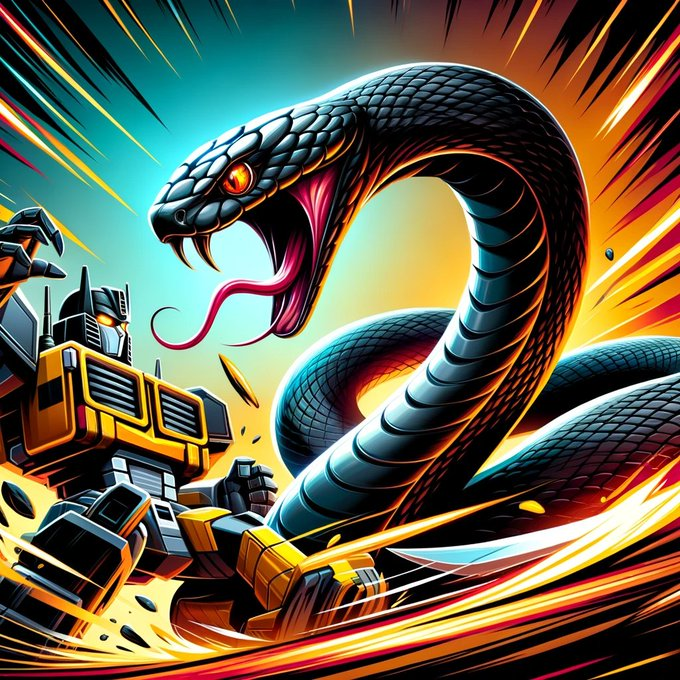

<small> Source: From the author's tweet </small>

Welcome to the Week 8 Tutorial! 

Here, we will discuss a new architecture of NLP, Mamba! 

To recap, Mamba has better long-dependency capture due to its state space modeling. Unlike Transformers which rely on attention (HEAVY), Mamba has better efficiency to process a sequence of input. That's why it's been a hit, lately!



The objectives of this lab are as follows:
1. Understanding the technical details of Mamba by implementing it!

As always, feel free to ask us :)

---

## Import + All Layer except Mamba Block

In [ ]:
from __future__ import annotations
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from einops import rearrange, repeat, einsum
from typing import Union
from transformers.utils import WEIGHTS_NAME, CONFIG_NAME
from transformers.utils.hub import cached_file

In [40]:
@dataclass
class ModelArgs:
    d_model: int
    n_layer: int
    vocab_size: int
    d_state: int = 16
    expand: int = 2
    dt_rank: Union[int, str] = 'auto'
    d_conv: int = 4 
    pad_vocab_size_multiple: int = 8
    conv_bias: bool = True
    bias: bool = False
    
    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)
        
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)
            
        if self.vocab_size % self.pad_vocab_size_multiple != 0:
            self.vocab_size += (self.pad_vocab_size_multiple
                                - self.vocab_size % self.pad_vocab_size_multiple)

In [41]:
class RMSNorm(nn.Module):
    def __init__(self,
                 d_model: int,
                 eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))


    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

        return output

In [42]:
class ResidualBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """Simple block wrapping Mamba block with normalization and residual connection."""
        super().__init__()
        self.args = args
        self.mixer = MambaBlock(args)
        self.norm = RMSNorm(args.d_model)

    def forward(self, x):
        """
        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)
    
        Returns:
            output: shape (b, l, d)

        Official Implementation:
            Block.forward(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L297
            
            Note: the official repo chains residual blocks that look like
                [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> ...
            where the first Add is a no-op. This is purely for performance reasons as this
            allows them to fuse the Add->Norm.

            We instead implement our blocks as the more familiar, simpler, and numerically equivalent
                [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> ....
            
        """
        output = self.mixer(self.norm(x)) + x

        return output
            

class RMSNorm(nn.Module):
    def __init__(self,
                 d_model: int,
                 eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))


    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

        return output

class Mamba(nn.Module):
    def __init__(self, args: ModelArgs):
        """Full Mamba model."""
        super().__init__()
        self.args = args
        
        self.embedding = nn.Embedding(args.vocab_size, args.d_model)
        self.layers = nn.ModuleList([ResidualBlock(args) for _ in range(args.n_layer)])
        self.norm_f = RMSNorm(args.d_model)

        self.lm_head = nn.Linear(args.d_model, args.vocab_size, bias=False)
        self.lm_head.weight = self.embedding.weight  # Tie output projection to embedding weights.
                                                     # See "Weight Tying" paper


    def forward(self, input_ids):
        """
        Args:
            input_ids (long tensor): shape (b, l)    (See Glossary at top for definitions of b, l, d_in, n...)
    
        Returns:
            logits: shape (b, l, vocab_size)

        Official Implementation:
            class MambaLMHeadModel, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/models/mixer_seq_simple.py#L173

        """
        x = self.embedding(input_ids)
        
        for layer in self.layers:
            x = layer(x)
            
        x = self.norm_f(x)
        logits = self.lm_head(x)

        return logits

    
    @staticmethod
    def from_pretrained(pretrained_model_name: str):
        """Load pretrained weights from HuggingFace into model.
    
        Args:
            pretrained_model_name: One of
                * 'state-spaces/mamba-2.8b-slimpj'
                * 'state-spaces/mamba-2.8b'
                * 'state-spaces/mamba-1.4b'
                * 'state-spaces/mamba-790m'
                * 'state-spaces/mamba-370m'
                * 'state-spaces/mamba-130m'
                            
        Returns:
            model: Mamba model with weights loaded
    
        """
        
        
        def load_config_hf(model_name):
            resolved_archive_file = cached_file(model_name, CONFIG_NAME,
                                                _raise_exceptions_for_missing_entries=False)
            return json.load(open(resolved_archive_file))
        
        
        def load_state_dict_hf(model_name, device=None, dtype=None):
            resolved_archive_file = cached_file(model_name, WEIGHTS_NAME,
                                                _raise_exceptions_for_missing_entries=False)
            return torch.load(resolved_archive_file, weights_only=True, map_location='cpu', mmap=True)
        
        config_data = load_config_hf(pretrained_model_name)
        args = ModelArgs(
            d_model=config_data['d_model'],
            n_layer=config_data['n_layer'],
            vocab_size=config_data['vocab_size']
        )
        model = Mamba(args)
        
        state_dict = load_state_dict_hf(pretrained_model_name)
        new_state_dict = {}
        for key in state_dict:
            new_key = key.replace('backbone.', '')
            new_state_dict[new_key] = state_dict[key]
        model.load_state_dict(new_state_dict)
        
        return model

## This is the Mamba Block

We will update this section iteratively!

In [ ]:

class MambaBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """A single Mamba block, as described in Figure 3 in Section 3.4 in the Mamba paper [1]."""
        super().__init__()
        self.args = args

        self.in_proj = nn.Linear(args.d_model, args.d_inner * 2, bias=args.bias)

        self.conv1d = nn.Conv1d(
            in_channels=args.d_inner,
            out_channels=args.d_inner,
            bias=args.conv_bias,
            kernel_size=args.d_conv,
            groups=args.d_inner,
            padding=args.d_conv - 1,
        )

        # x_proj takes in `x` and outputs the input-specific Δ, B, C
        self.x_proj = nn.Linear(args.d_inner, args.dt_rank + args.d_state * 2, bias=False)
        
        # dt_proj projects Δ from dt_rank to d_in
        self.dt_proj = nn.Linear(args.dt_rank, args.d_inner, bias=True)

        A = repeat(torch.arange(1, args.d_state + 1), 'n -> d n', d=args.d_inner)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(args.d_inner))
        self.out_proj = nn.Linear(args.d_inner, args.d_model, bias=args.bias)
        

    def forward(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba paper [1].
    
        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)
    
        Returns:
            output: shape (b, l, d)
        
        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
            
        """
        (b, l, d) = x.shape
        
        x_and_res = self.in_proj(x)  # shape (b, l, 2 * d_in)
        (x, res) = x_and_res.split(split_size=[self.args.d_inner, self.args.d_inner], dim=-1)

        x = rearrange(x, 'b l d_in -> b d_in l')
        x = self.conv1d(x)[:, :, :l]
        x = rearrange(x, 'b d_in l -> b l d_in')
        
        x = F.silu(x)

        y = self.ssm(x)
        
        y = y * F.silu(res)
        
        output = self.out_proj(y)

        return output

    
    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        Args:
            x: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)
    
        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311
            
        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)
        
        A = -torch.exp(self.A_log.float())  # shape (d_in, n)
        D = self.D.float()

        x_dbl = self.x_proj(x)  # (b, l, dt_rank + 2*n)
        
        (delta, B, C) = x_dbl.split(split_size=[self.args.dt_rank, n, n], dim=-1)  # delta: (b, l, dt_rank). B, C: (b, l, n)
        delta = F.softplus(self.dt_proj(delta))  # (b, l, d_in)
        
        y = self.selective_scan(x, delta, A, B, C, D)  # This is similar to run_SSM(A, B, C, u) in The Annotated S4 [2]
        
        return y

    
    def selective_scan(self, u, delta, A, B, C, D):
        """Does selective scan algorithm. See:
            - Section 2 State Space Models in the Mamba paper [1]
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        This is the classic discrete state space formula:
            x(t + 1) = Ax(t) + Bu(t)
            y(t)     = Cx(t) + Du(t)
        except B and C (and the step size delta, which is used for discretization) are dependent on the input x(t).
    
        Args:
            u: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)
            delta: shape (b, l, d_in)
            A: shape (d_in, n)
            B: shape (b, l, n)
            C: shape (b, l, n)
            D: shape (d_in,)
    
        Returns:
            output: shape (b, l, d_in)
    
        Official Implementation:
            selective_scan_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L86            
        """
        (b, l, d_in) = u.shape
        n = A.shape[1]
        
        # Discretize continuous parameters (A, B)
        # - A is discretized using zero-order hold (ZOH) discretization (see Section 2 Equation 4 in the Mamba paper [1])
        # - B is discretized using a simplified Euler discretization instead of ZOH. From a discussion with authors:
        #   "A is the more important term and the performance doesn't change much with the simplification on B"
        deltaA = torch.exp(einsum(delta, A, 'b l d_in, d_in n -> b l d_in n'))
        deltaB_u = einsum(delta, B, u, 'b l d_in, b l n, b l d_in -> b l d_in n')
        
        # Perform selective scan (see scan_SSM() in The Annotated S4 [2])
        # Note that the below is sequential, while the official implementation does a much faster parallel scan that
        # is additionally hardware-aware (like FlashAttention).
        x = torch.zeros((b, d_in, n), device=deltaA.device)
        ys = []    
        for i in range(l):
            x = deltaA[:, i] * x + deltaB_u[:, i]
            y = einsum(x, C[:, i, :], 'b d_in n, b n -> b d_in')
            ys.append(y)
        y = torch.stack(ys, dim=1)  # shape (b, l, d_in)
        
        y = y + u * D
    
        return y

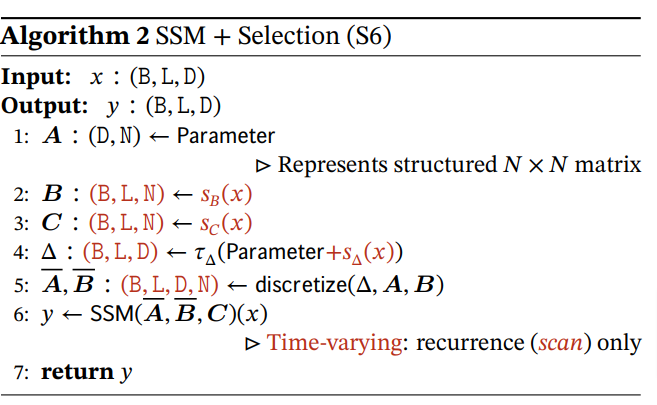

## Initialize these variables

- `self.in_proj`: A linear transformation layer that projects the input feature dimension (`args.d_model`) to a larger, intermediate dimension (`args.d_inner * 2`). The `bias` parameter is configurable.
- `self.conv1d`: A 1-dimensional convolutional layer designed for processing sequential data. It operates on `args.d_inner` channels with a kernel size of `args.d_conv` and applies grouping to each channel independently. Padding is applied to maintain the sequence length.
- `self.out_proj`: A linear transformation layer that projects the input feature dimension (`args.d_inner`) to a larger, intermediate dimension (`args.d_model`). The `bias` parameter is configurable.



## Implement it step by step

Create these variables based on the algorithm:

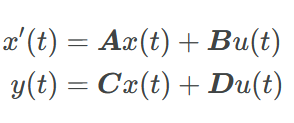

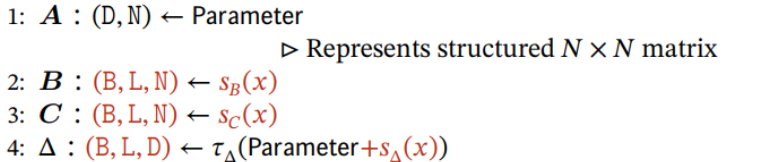

## `A`
- `A`: A tensor generated by repeating a range from 1 to `args.d_state + 1` across `args.d_inner` dimensions, used for constructing the matrix `A` in subsequent operations. This tensor is logarithmically transformed and wrapped in `nn.Parameter` to allow gradient updates, denoted as `self.A_log`. 

For instance: args.d_state+1 = 5 and d_model = 2:

```
1 2 3 4 5
1 2 3 4 5
```

## `B` `C` `Δ`


`self.x_proj`: A linear layer that maps the intermediate representation (`args.d_inner`) to a combined space for input-specific Δ, B, C, with dimensions determined by `args.dt_rank` for (Δ) and two of `args.d_state` (for B, C), without bias.

` self.dt_proj`: Another linear transformation that projects Δ from a reduced rank space (`args.dt_rank`) back to the intermediate dimension (`args.d_inner`), incorporating bias.

Note: This can be interpreted as having three linear layer for three of those variables.


## `D`

D can be viewed as a skip connection here.

- `self.D`: A learnable parameter initialized as a vector of ones with dimension `args.d_inner`, representing a diagonal matrix in further computations.

Those are for the initialization well done!

Now, let's move one to code the forward

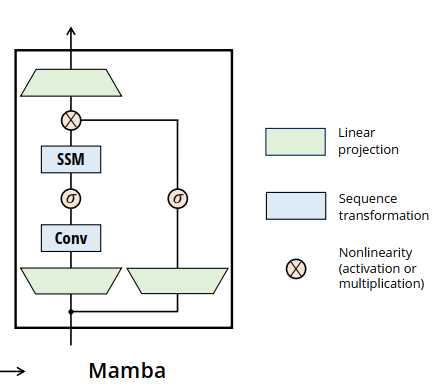

## Let's implement these first
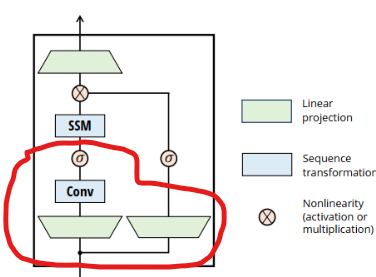


## Next

Given an input tensor `x` with shape `(b, l, d)`, where:
- `b` is the batch size,
- `l` is the sequence length, and
- `d` is the feature dimension,

the following operations are performed:

### 1. Input Projection
First, `x` is passed through an input projection linear layer `self.in_proj`:

$$
\mathbf{X}_{\text{and\_res}} = \mathbf{W}_{\text{in\_proj}} \mathbf{X} + \mathbf{b}_{\text{in\_proj}}
$$

where $\mathbf{W}_{\text{in\_proj}}$ and $\mathbf{b}_{\text{in\_proj}}$ are the weight and bias of the `self.in_proj` layer, respectively. The resulting tensor $\mathbf{X}_{\text{and\_res}}$ has shape `(b, l, 2 * d_in)`.

### 2. Splitting Tensor
The output is then split into two tensors `x` and `res` along the last dimension, each with shape `(b, l, d_in)`:

### 3. Convolutional Layer
Before applying the convolutional operation, `x` is rearranged to fit the expected input shape of the `nn.Conv1d` layer


Then, a 1D convolution is applied:

$$
\mathbf{X}_{\text{conv}} = \text{Conv1D}(\mathbf{X}_{\text{rearranged}})
$$

To ensure the output length matches the original sequence length `l`, we slice the tensor:

$$
\mathbf{X}_{\text{conv}} = \mathbf{X}_{\text{conv}}[:, :, :l]
$$

Finally, the tensor is rearranged back to its original shape `(b, l, d_{\text{in}})`:

### 4. Silu

Apply SiLU (Sigmoid with learnable weight) to the CNN output directly

### Write your implementation

Write your implementation directly to our class afterward

## Tips

**Tips**: 

Don't directly code into the function. Play around with these implementation first to grasp the idea. <br>
Try generating a random input (e.g.: using `torch.randn`) and code outside the cell and check its input output. <br>
Check its dimension to ascertain that this is what you want

**Another tips**: Document your tensor shape to keep track of it.

## Here we go, the most interesting part, SSM model!

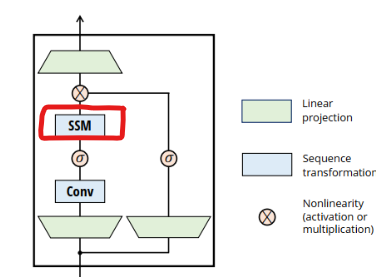
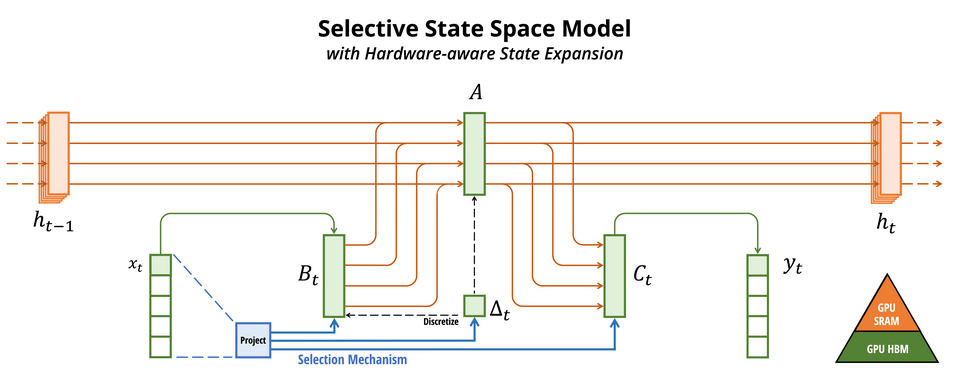

Let's obtain the continuous ∆, B and C which are input dependent. On the other hand, A and D are input independent

## Steps



### 1. Matrix `A` Initialization
  $$
  A = -\exp(\mathbf{A}_{\log})
  $$

### 2. Vector `D` Initialization

Transform to Float Tensor

### 3. Projection of `x` through `self.x_proj`


- `x` is projected through a linear layer `self.x_proj`, resulting in a tensor `x_dbl` of shape `(b, l, dt_rank + 2*n)`. This layer expands the dimensionality of `x` to include additional features for Δ, B, and C.
  
### 4. Splitting `x_dbl` into Δ, B, and C

- The tensor `x_dbl` is split into three tensors: `delta`, `B`, and `C`, with shapes `(b, l, dt_rank)`, `(b, l, n)`, and `(b, l, n)`

Tips: use .split to get each tensor for delta, B, and C

### 5. Transformation of Δ through `self.dt_proj` and Softplus Activation

```python
delta = F.softplus(self.dt_proj(delta))  # (b, l, d_in)
```

The tensor Δ is then passed through another linear projection `self.dt_proj` (based ont the paper Section 3.6). Afterward do a softplus (Smooth approximation of Relu with smoothness parameter (beta))

### 6. Transformation of Δ through `self.dt_proj` and Softplus Activation

### 7. Afterward call this function that we will implement

```
y = self.selective_scan(x, delta, A, B, C, D)
```

## Selective Scan with Discretization

Implement the `selective_scan` following these steps:


### 1. Discretization

First of all, discretize your A (deltaA) as follow:

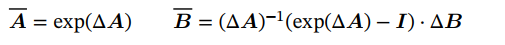

We don't simplify B by using that equation. From the authors' perspective, simplify B does not detrimental the perfromance. 

To simplify B, rather than using Zero-order hold (ZOH) discretization, we use 

To explain the equation involving `einsum` and provide a mathematical notation for obtaining `deltaB_u`, we need to understand the operation being performed and the dimensions involved in the tensors `delta`, `B`, and `u`.

(Discretize B with delta, then multiply by U)
```
deltaB_u = einsum(delta, B, u, 'b l d_in, b l n, b l d_in -> b l d_in n')
```

Afterward, do SCANNING

### 2. Scanning

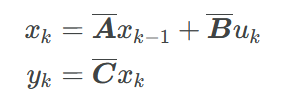

The original implementation use hardware-aware algorithm O(log n). However, since it would be much to do that in this lab, we use the sequential approach instead O(N).
D is used as a skip connection for the output.

#### Pseudocode

1. Initialize tensor `x` with zeros, having shape (b, d_in, n), on the same device as `deltaA`.
2. Initialize an empty list `ys` to store intermediate results.
3. For each index `i` in the range of `l` (sequence of state):
   a. Update `x` by performing an element-wise multiplication of `deltaA[:, i]` with `x`, 
      then adding `deltaB_u[:, i]` to this product.
   b. Compute `y` by performing a tensor contraction between `x` and `C[:, i, :]`, 
      reducing over the last dimension of `C` to match the dimensions of `x`.
   c. Append the computed `y` to the list `ys`.
4. Stack the tensors in `ys` along a new dimension `1` to form a single tensor `y` 
   with shape (b, l, d_in), aligning the sequence dimension.
5. Update `y` by adding the product of `u` and `D`, where `u` is element-wise multiplied by `D` 
   before being added to `y`, facilitating a scaling operation on `u`.
6. Return the final tensor `y`.


## Don't forget this part!! Implement it!

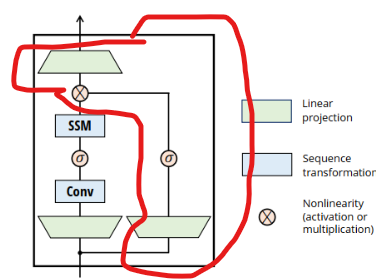

Use SiLU as the nonlinearity and multiply it by the output of SSM. Then project it out using `out_project` linear layer

Your code is done! Try your mamba for end-to-end random sequence!


In [51]:
args = ModelArgs(
    d_model=64,
    n_layer=2,
    vocab_size=50
)

In [52]:
mamba = Mamba(args)
input_ids = torch.randint(0, 50, (2, 10))
logits = mamba(input_ids)

torch.Size([2, 10, 56])

 **GOOD TO TRY**: <br>
 
 <p style="color:blue;">Try to finetune your mamba to any data (e.g.: tweeteval) and test it by downloading the weight from the Huggingface!</p>
 <p>Compare the result with a comparable DeBERTa model. how is it?</p>

Creatively test the data. For instance, test a long dataset and compare its performance with Transformers-based model.


 <center><h1>Challenge: Play Around With Mamba</h1></center>
 
- Remove CNN Layer, does it impact the result?
-  Mamba has a weakness that struggle to copy a uniform input sequence accordng to [This paper](https://arxiv.org/abs/2402.01032). Test it to an artificial dataset of several palindroms (e.g.: H A R Y O -> O Y R A H). Analyze it!
- Try doing PEFT with mamba (LoRA, Adapter), how's the performance?



<center><h1 style="color:red"> MORE CHALLENGE: Nightmare Difficulty</h1></center>

<center><p style="color:red"><b>DO NOT TRY IF YOU DON'T HAVE TIME AND VALUE YOUR SANITY</b></p></center>

- Code the Selective Scan in C++/Rust that incorporates GPU cores to run the algorithm.
- Create an inference code like llama.cpp for Mamba (using C++/Rust instead of Python)
- Create a training code in C++/Rust instead of Python to make it blazingly fast (like [Marian Library](https://marian-nmt.github.io/))



```
Simple, minimal implementation of Mamba in one file of PyTorch.

Suggest reading the following before/while reading the code:
    [1] Mamba: Linear-Time Sequence Modeling with Selective State Spaces (Albert Gu and Tri Dao)
        https://arxiv.org/abs/2312.00752
    [2] The Annotated S4 (Sasha Rush and Sidd Karamcheti)
        https://srush.github.io/annotated-s4

Glossary:
    b: batch size                       (`B` in Mamba paper [1] Algorithm 2)
    l: sequence length                  (`L` in [1] Algorithm 2)
    d or d_model: hidden dim
    n or d_state: latent state dim      (`N` in [1] Algorithm 2)
    expand: expansion factor            (`E` in [1] Section 3.4)
    d_in or d_inner: d * expand         (`D` in [1] Algorithm 2)
    A, B, C, D: state space parameters  (See any state space representation formula)
                                        (B, C are input-dependent (aka selective, a key innovation in Mamba); A, D are not)
    Δ or delta: input-dependent step size
    dt_rank: rank of Δ                  (See [1] Section 3.6 "Parameterization of ∆")
```

Source: https://github.com/johnma2006/mamba-minimal/
